[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

First few rows of the merged DataFrame:
                  DBO        WTI        DXY
2010-01-01  24.655401  81.510002  77.529999
2010-01-02  24.655401  81.510002  77.529999
2010-01-03  24.655401  81.510002  77.529999
2010-01-04  24.655401  81.510002  77.529999
2010-01-05  24.883612  81.769997  77.620003


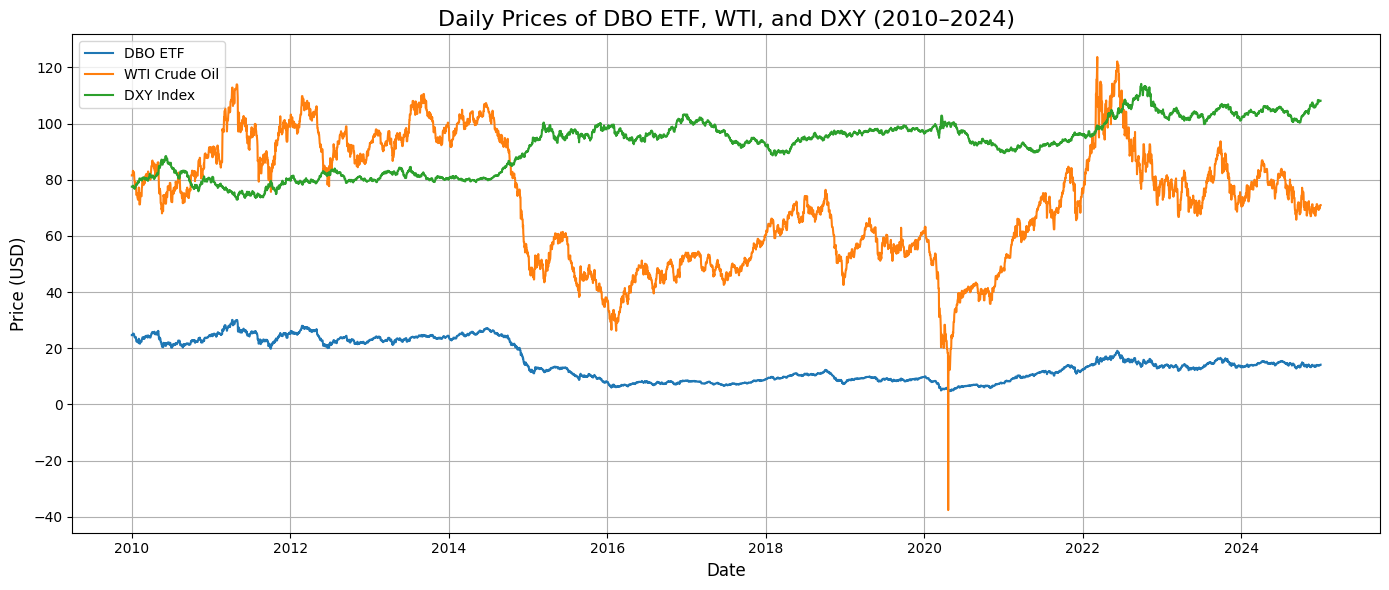

In [15]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define ticker symbols and corresponding Yahoo Finance symbols:
tickers = {
    "DBO": "DBO",          # Invesco DB Oil Fund ETF
    "WTI": "CL=F",         # WTI Crude Oil Futures
    "DXY": "DX-Y.NYB"      # U.S. Dollar Index
}

# Set the date range for data collection
start_date = "2010-01-01"
end_date = "2024-12-31"

# Download daily close price data for each ticker
price_data = {}
for label, symbol in tickers.items():
    df = yf.download(symbol, start=start_date, end=end_date)
    # Extract the "Close" column for each asset
    price_data[label] = df["Close"]

# Merge the individual Series into a single DataFrame.
# This produces a MultiIndex; we drop the inner level.
data = pd.concat(price_data, axis=1)
data.columns = data.columns.droplevel(1)  # Now columns are 'DBO', 'WTI', 'DXY'

# Create a complete daily date range (including non-trading days)
all_days = pd.date_range(start=start_date, end=end_date, freq='D')
data = data.reindex(all_days)

# Ensure the index is a DateTimeIndex with daily frequency
data.index = pd.to_datetime(data.index)
data = data.asfreq('D')

# Replace any Inf or -Inf with NaN
data = data.replace([np.inf, -np.inf], np.nan)

# Handle missing values: first forward fill, then backward fill, then interpolate any remaining gaps
data = data.ffill().bfill().interpolate()

# Show the first few rows of the merged DataFrame
print("First few rows of the merged DataFrame:")
print(data.head())

# Visualization using the provided code snippet:
plt.figure(figsize=(14, 6))
plt.plot(data.index, data['DBO'], label='DBO ETF')
plt.plot(data.index, data['WTI'], label='WTI Crude Oil')
plt.plot(data.index, data['DXY'], label='DXY Index')

plt.title('Daily Prices of DBO ETF, WTI, and DXY (2010–2024)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Missing values in training set (before modeling):
DBO    0
WTI    0
DXY    0
dtype: int64

Missing values in test set (before forecasting):
WTI    0
DXY    0
dtype: int64

ADF Statistic: -0.9981
p-value: 0.7539
Differencing order applied: 1

ARIMAX Model Summary:
                               SARIMAX Results                                
Dep. Variable:                    DBO   No. Observations:                 3652
Model:               SARIMAX(1, 1, 1)   Log Likelihood                3281.590
Date:                Mon, 14 Apr 2025   AIC                          -6553.179
Time:                        16:16:50   BIC                          -6522.168
Sample:                    01-01-2010   HQIC                         -6542.135
                         - 12-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------

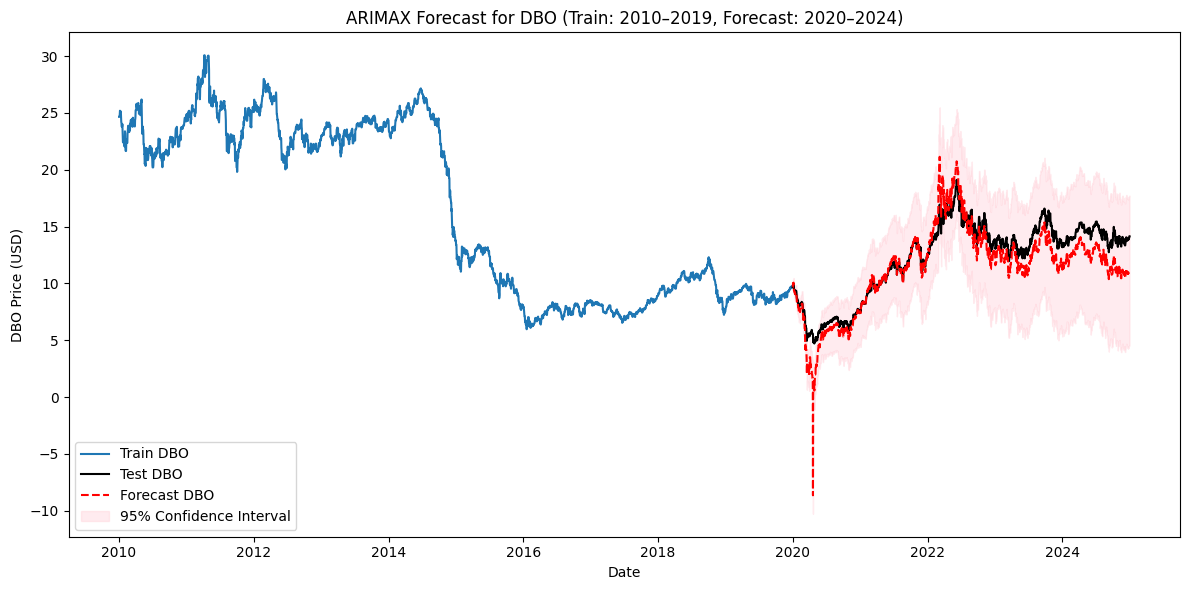

In [17]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

# --- Ensure the data index is a DateTimeIndex with daily frequency ---
data.index = pd.to_datetime(data.index)
data = data.asfreq('D')

# --- Split data into training (2010–2019) and testing (2020–2024) sets ---
train = data.loc['2010-01-01':'2019-12-31']
test = data.loc['2020-01-01':'2024-12-31']

# --- Optional: Final check to confirm no NaNs in the critical columns ---
print("Missing values in training set (before modeling):")
print(train[['DBO', 'WTI', 'DXY']].isna().sum())
print("\nMissing values in test set (before forecasting):")
print(test[['WTI', 'DXY']].isna().sum())

# --- Stationarity Test on DBO (target) using Augmented Dickey-Fuller (ADF) ---
adf_result = adfuller(train['DBO'].dropna())
print('\nADF Statistic: {:.4f}'.format(adf_result[0]))
print('p-value: {:.4f}'.format(adf_result[1]))

# Set differencing order based on the ADF test p-value (d=1 if non-stationary, else d=0)
d_order = 1 if adf_result[1] > 0.05 else 0
print("Differencing order applied:", d_order)

# --- Build the ARIMAX Model using SARIMAX ---
# Using a simple ARIMA order of (1, d_order, 1)
model = SARIMAX(train['DBO'],
                exog=train[['WTI', 'DXY']],
                order=(1, d_order, 1),
                enforce_stationarity=False,
                enforce_invertibility=False)
model_fit = model.fit(disp=False)
print("\nARIMAX Model Summary:")
print(model_fit.summary())

# --- Forecasting for the period 2020–2024 ---
forecast_steps = len(test)
print("\nForecast steps:", forecast_steps)

# Ensure that the exogenous test DataFrame matches the forecast period's length
print("Test exogenous variables shape:", test[['WTI', 'DXY']].shape)

forecast_res = model_fit.get_forecast(steps=forecast_steps, exog=test[['WTI', 'DXY']])
forecast_mean = forecast_res.predicted_mean
forecast_ci = forecast_res.conf_int()

# --- Visualization of the forecast ---
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['DBO'], label='Train DBO')
plt.plot(test.index, test['DBO'], label='Test DBO', color='black')
plt.plot(test.index, forecast_mean, label='Forecast DBO', color='red', linestyle='--')
plt.fill_between(test.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1],
                 color='pink', alpha=0.3, label='95% Confidence Interval')
plt.title('ARIMAX Forecast for DBO (Train: 2010–2019, Forecast: 2020–2024)')
plt.xlabel('Date')
plt.ylabel('DBO Price (USD)')
plt.legend()
plt.tight_layout()
plt.show()


X_seq shape: (1758, 20, 5)
y_seq shape: (1758, 1)


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 20, 50)         │        11,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,451 (122.86 KB)

 Trainable params: 31,451 (122.86 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0795 - val_loss: 0.0018
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0062 - val_loss: 6.6981e-04
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0048 - val_loss: 0.0012
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0046 - val_loss: 6.2084e-04
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0041 - val_loss: 0.0012
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0040 - val_loss: 0.0013
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0037 - val_loss: 0.0014
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0040 - val_loss: 5.3512e-04
Epoch 9/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0034 - val_loss: 8.1032e-04
Epoch 10/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0033 - val_loss: 5.2508e-04
Epoch 11/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0029 - val_loss: 5.2344e-04
Epoch 12/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

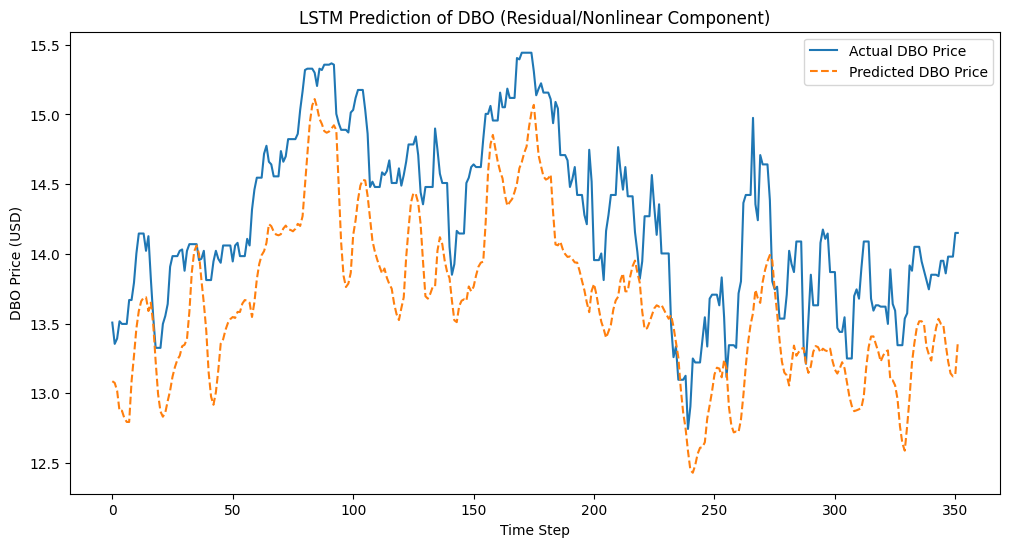

In [20]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# -----------------------
# Prepare Data for LSTM
# -----------------------

# Work on the test period (2020–2024). Copy your test DataFrame.
test_lstm = test.copy()

# --- Merge ARIMAX forecast values ---
# The ARIMAX forecast (forecast_mean) should have the same index as test.
test_lstm["ARIMAX_Forecast"] = forecast_mean

# --- Compute Technical Indicators ---
# Example 1: Moving Averages (10-day and 50-day)
test_lstm["MA10"] = test_lstm["DBO"].rolling(window=10).mean()
test_lstm["MA50"] = test_lstm["DBO"].rolling(window=50).mean()

# Example 2: RSI (Relative Strength Index)
def compute_RSI(series, window=14):
    delta = series.diff(1)
    gain = delta.where(delta > 0, 0.0)
    loss = -delta.where(delta < 0, 0.0)
    avg_gain = gain.rolling(window=window, min_periods=window).mean()
    avg_loss = loss.rolling(window=window, min_periods=window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

test_lstm["RSI"] = compute_RSI(test_lstm["DBO"], window=14)

# Drop rows with NaN values (created by rolling computations)
test_lstm.dropna(inplace=True)

# --- Define Features and Target ---
# Input features: Original DBO close, MA10, MA50, RSI, and ARIMAX forecast.
features = ["DBO", "MA10", "MA50", "RSI", "ARIMAX_Forecast"]
target = "DBO"  # Our goal is to predict the DBO close

# -----------------------
# Scale the Data
# -----------------------

# Initialize scalers for input features and target.
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Scale features and target; note that scaler_y expects a 2D array.
X_scaled = scaler_X.fit_transform(test_lstm[features])
y_scaled = scaler_y.fit_transform(test_lstm[[target]])

# -----------------------
# Create Sequences for the LSTM
# -----------------------

def create_sequences(X, y, seq_length):
    """
    Creates sequences of length seq_length from X and y.
    X: array of features, y: target array.
    Returns:
        X_seq: 3D numpy array of shape (num_samples, seq_length, num_features)
        y_seq: 2D numpy array of shape (num_samples, 1)
    """
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:(i + seq_length)])
        y_seq.append(y[i + seq_length])
    return np.array(X_seq), np.array(y_seq)

seq_length = 20  # Example: use a 20-day look-back window
X_seq, y_seq = create_sequences(X_scaled, y_scaled, seq_length)

print("X_seq shape:", X_seq.shape)
print("y_seq shape:", y_seq.shape)

# -----------------------
# Train/Test Split for LSTM (within test period)
# -----------------------

# Split sequences into training and testing sets (e.g., 80%-20% split)
split_ratio = 0.8
split_idx = int(len(X_seq) * split_ratio)
X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]

# -----------------------
# Build the LSTM Model
# -----------------------

model = Sequential()
model.add(LSTM(50, activation='tanh', return_sequences=True,
               input_shape=(seq_length, X_seq.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

# -----------------------
# Train the Model
# -----------------------

history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_test, y_test),
                    verbose=1)

# -----------------------
# Evaluate and Visualize the Model Predictions
# -----------------------

# Predict on the test set
y_pred = model.predict(X_test)

# Inverse transform predictions and true values to original scale
y_pred_inv = scaler_y.inverse_transform(y_pred)
y_test_inv = scaler_y.inverse_transform(y_test)

# Plot predictions vs actual DBO prices
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Actual DBO Price')
plt.plot(y_pred_inv, label='Predicted DBO Price', linestyle='--')
plt.title("LSTM Prediction of DBO (Residual/Nonlinear Component)")
plt.xlabel("Time Step")
plt.ylabel("DBO Price (USD)")
plt.legend()
plt.show()
